In [22]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from math import log




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Correlation between the weighted price index and PILANIINVS.NS: 0.87


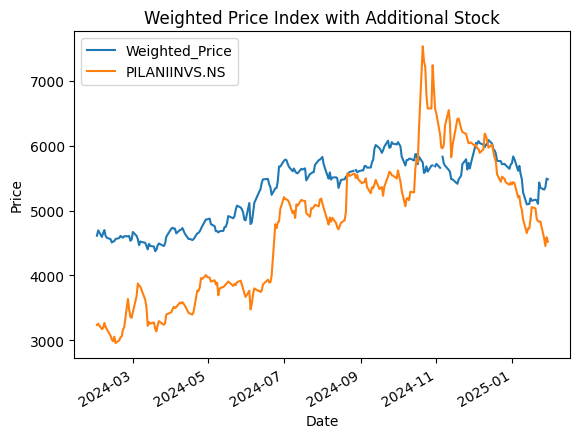

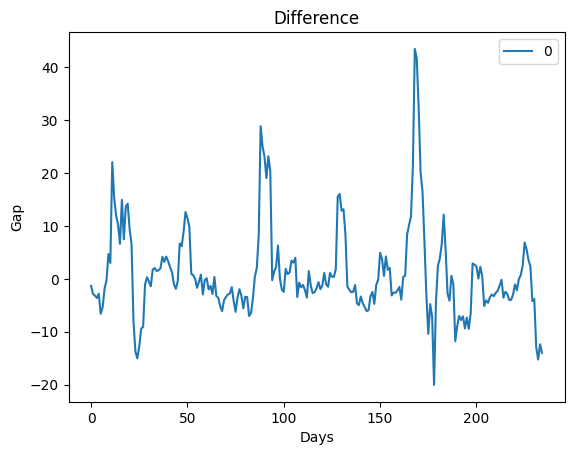

In [168]:




def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Adj Close']

def calculate_weighted_price(stock_data_dict, weights):
    return sum(stock_data * weight for stock_data, weight in zip(stock_data_dict.values(), weights))

def plot_weighted_price_and_correlation(stock_data_dict, weights, additional_stock_data, additional_stock_label):
    # Calculate the weighted price
    weighted_price = calculate_weighted_price(stock_data_dict, weights)
    
    # Create a DataFrame with both series
    df = pd.DataFrame({'Weighted_Price': weighted_price, additional_stock_label: additional_stock_data})

    # Calculate correlation using Pandas
    correlation = df.corr().loc['Weighted_Price', additional_stock_label]
    print(f'Correlation between the weighted price index and {additional_stock_label}: {correlation:.2f}')

    # Plot the data
    df.plot()
    plt.title('Weighted Price Index with Additional Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
def log_returns(stock_data_dict, weights, isIndex, start_date, end_date):
    log_price = []
    if isIndex == 1:
        price_data = list(calculate_weighted_price(stock_data_dict, weights).values)
    else:
        price_data = list(yf.download(stock_data_dict, start=start_date, end=end_date)['Adj Close'].values)
    for i in range(6, len(price_data)):
        log_price.append(((price_data[i]/price_data[i-6])-1)*100)
    return log_price
def main():
    # Define the stocks and their weights
    stocks = ['ABREL.NS', 'KESORAMIND.NS', 'MANGLMCEM.BO', 'ULTRACEMCO.BO', 'ABFRL.NS','IDEA.NS','PILANIINVS.NS']
    weights = [0.482, 0.087, 0.012, 0.391,0.010, 0.019]  # You can customize the weights as per your preference

    # User input for date range
    start_date = '2024-02-01'
    end_date = '2025-01-31'

    # Fetch stock data
    stock_data_dict = {ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in stocks[:-1]}  # Exclude the last stock
    additional_stock_data = fetch_stock_data(stocks[-1], start_date, end_date)
    additional_stock_label = stocks[-1]
    holding_returns = log_returns(stock_data_dict, weights, 1, start_date, end_date)
    main_company_returns = log_returns(additional_stock_label, weights, 0, start_date, end_date)
    list = []
    for i in range(len(holding_returns)):
        if str(holding_returns[i]-main_company_returns[i]) != 'nan':
            list.append(main_company_returns[i]-holding_returns[i])
        else: continue
    #print(list)
    #print(sorted(list))
    # Plot the weighted price index with the additional stock and calculate correlation
    plot_weighted_price_and_correlation(stock_data_dict, weights, additional_stock_data, additional_stock_label)
    data = pd.DataFrame(list)
    data.plot()
    plt.title('Difference')
    plt.xlabel('Days')
    plt.ylabel('Gap')
    plt.legend()
    plt.show()
if __name__ == "__main__":
    main()


## 